In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

Import the csv file here

In [2]:
csv_path = "clv_predictions.csv"
df = pd.read_csv(csv_path)
df.head()

,customer_id,true_value,predicted_value,customer_segment,transaction_date
0,1001,1935.246582,1904.645470,New,2024-01-01
1,1002,4758.500101,4768.951518,Regular,2024-01-02
2,1003,3686.770315,3699.958576,Regular,2024-01-03
3,1004,3033.426573,3001.280759,New,2024-01-04
4,1005,864.491338,948.451191,New,2024-01-05


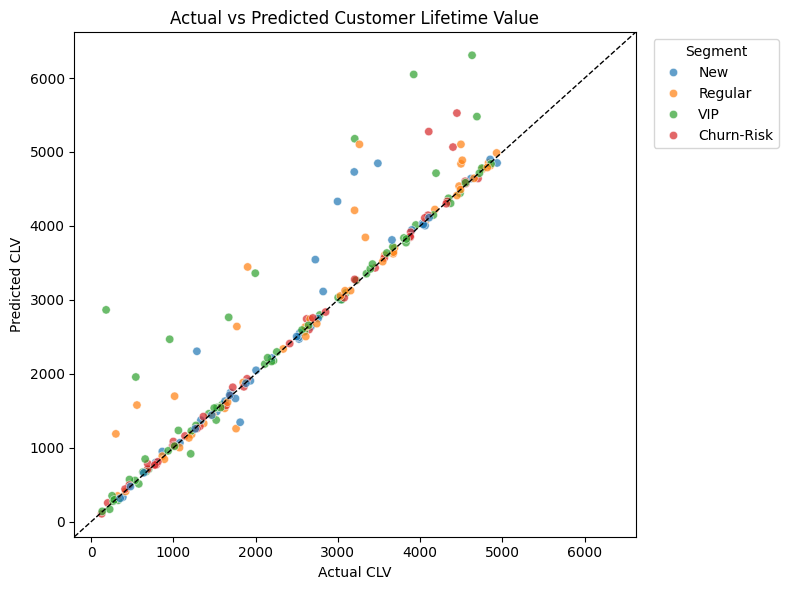

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df, x="true_value", y="predicted_value", hue="customer_segment", alpha=0.7, ax=ax)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle="--", color="black", linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title("Actual vs Predicted Customer Lifetime Value")
ax.set_xlabel("Actual CLV")
ax.set_ylabel("Predicted CLV")
ax.legend(title="Segment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23524\1531681873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_errors, x="customer_segment", y="mean_absolute_error", palette="viridis", ax=ax)


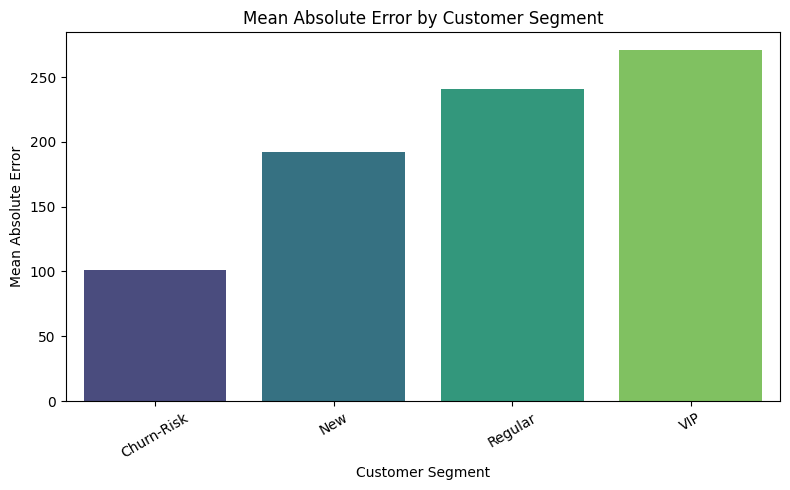

In [4]:
segment_errors = (
    df.assign(abs_error=(df["predicted_value"] - df["true_value"]).abs())
      .groupby("customer_segment", as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error": "mean_absolute_error"})
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=segment_errors, x="customer_segment", y="mean_absolute_error", palette="viridis", ax=ax)
ax.set_title("Mean Absolute Error by Customer Segment")
ax.set_xlabel("Customer Segment")
ax.set_ylabel("Mean Absolute Error")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

In [5]:
csv_path = "clv_predictions.csv"
df = pd.read_csv(csv_path)
df.head()

,customer_id,true_value,predicted_value,customer_segment,transaction_date
0,1001,1935.246582,1904.645470,New,2024-01-01
1,1002,4758.500101,4768.951518,Regular,2024-01-02
2,1003,3686.770315,3699.958576,Regular,2024-01-03
3,1004,3033.426573,3001.280759,New,2024-01-04
4,1005,864.491338,948.451191,New,2024-01-05


In [16]:
X = df.drop(columns=["true_value", "customer_id", "transaction_date"])
X = pd.get_dummies(X, columns=["customer_segment"], drop_first=True)
y = df["true_value"]
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df["customer_segment"]
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Features: {list(X.columns)}")

Train shape: (160, 4), Test shape: (40, 4)
Features: ['predicted_value', 'customer_segment_New', 'customer_segment_Regular', 'customer_segment_VIP']


In [39]:

models_results = {}

In [40]:
# GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, Y_train)

train_pred = gb_model.predict(X_train)
test_pred = gb_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
train_r2 = r2_score(Y_train, train_pred)
test_r2 = r2_score(Y_test, test_pred)

n_features = X_train.shape[1]

print(f"Number of features used: {n_features}")
print(f"\nTrain RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"\nTrain R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

models_results['GradientBoostingRegressor'] = {
        'model': gb_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_pred': train_pred,
        'test_pred': test_pred
    }


Number of features used: 4

Train RMSE: 157.4234
Test RMSE: 526.8219

Train R² Score: 0.9886
Test R² Score: 0.8360


In [41]:
if HAS_XGBOOST:
    print("\n Training XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_model.fit(X_train, Y_train, verbose=False)
    
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)
    
    xgb_train_rmse = np.sqrt(mean_squared_error(Y_train, xgb_train_pred))
    xgb_test_rmse = np.sqrt(mean_squared_error(Y_test, xgb_test_pred))
    xgb_train_r2 = r2_score(Y_train, xgb_train_pred)
    xgb_test_r2 = r2_score(Y_test, xgb_test_pred)
    
    models_results['XGBoost'] = {
        'model': xgb_model,
        'train_rmse': xgb_train_rmse,
        'test_rmse': xgb_test_rmse,
        'train_r2': xgb_train_r2,
        'test_r2': xgb_test_r2,
        'train_pred': xgb_train_pred,
        'test_pred': xgb_test_pred
    }
    
    print(f"XGBoost - Train RMSE: {xgb_train_rmse:.4f}, Test RMSE: {xgb_test_rmse:.4f}")
    print(f"XGBoost - Train R²: {xgb_train_r2:.4f}, Test R²: {xgb_test_r2:.4f}")
else:
    print("\n XGBoost not installed. Skipping XGBoost model.")


 Training XGBoost...
XGBoost - Train RMSE: 8.6655, Test RMSE: 618.0501
XGBoost - Train R²: 1.0000, Test R²: 0.7743


In [42]:
# 4. Support Vector Machine (SVM)
print("\n Training Support Vector Machine (SVM)...")
# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svm_model.fit(X_train_scaled, Y_train)

svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

svm_train_rmse = np.sqrt(mean_squared_error(Y_train, svm_train_pred))
svm_test_rmse = np.sqrt(mean_squared_error(Y_test, svm_test_pred))
svm_train_r2 = r2_score(Y_train, svm_train_pred)
svm_test_r2 = r2_score(Y_test, svm_test_pred)

models_results['SVM'] = {
    'model': svm_model,
    'train_rmse': svm_train_rmse,
    'test_rmse': svm_test_rmse,
    'train_r2': svm_train_r2,
    'test_r2': svm_test_r2,
    'train_pred': svm_train_pred,
    'test_pred': svm_test_pred
}

print(f"SVM - Train RMSE: {svm_train_rmse:.4f}, Test RMSE: {svm_test_rmse:.4f}")
print(f"SVM - Train R²: {svm_train_r2:.4f}, Test R²: {svm_test_r2:.4f}")


 Training Support Vector Machine (SVM)...
SVM - Train RMSE: 585.6582, Test RMSE: 575.3781
SVM - Train R²: 0.8422, Test R²: 0.8044


In [43]:
# Linear Regression
print("\n Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

lr_train_rmse = np.sqrt(mean_squared_error(Y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(Y_test, lr_test_pred))
lr_train_r2 = r2_score(Y_train, lr_train_pred)
lr_test_r2 = r2_score(Y_test, lr_test_pred)

models_results['Linear Regression'] = {
    'model': lr_model,
    'train_rmse': lr_train_rmse,
    'test_rmse': lr_test_rmse,
    'train_r2': lr_train_r2,
    'test_r2': lr_test_r2,
    'train_pred': lr_train_pred,
    'test_pred': lr_test_pred
}

print(f"Linear Regression - Train RMSE: {lr_train_rmse:.4f}, Test RMSE: {lr_test_rmse:.4f}")
print(f"Linear Regression - Train R²: {lr_train_r2:.4f}, Test R²: {lr_test_r2:.4f}")




 Training Linear Regression...
Linear Regression - Train RMSE: 451.5448, Test RMSE: 357.3172
Linear Regression - Train R²: 0.9062, Test R²: 0.9246


In [44]:
comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train RMSE': results['train_rmse'],
        'Test RMSE': results['test_rmse'],
        'Train R²': results['train_r2'],
        'Test R²': results['test_r2']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Find best models
best_test_rmse = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_test_r2 = comparison_df.loc[comparison_df['Test R²'].idxmax()]

print(f"\n Best Model by Test RMSE: {best_test_rmse['Model']} (RMSE: {best_test_rmse['Test RMSE']:.4f})")
print(f"Best Model by Test R²: {best_test_r2['Model']} (R²: {best_test_r2['Test R²']:.4f})")



                     Model  Train RMSE  Test RMSE  Train R²  Test R²
GradientBoostingRegressor  157.423435 526.821947  0.988599 0.836013
                  XGBoost    8.665545 618.050144  0.999965 0.774301
                      SVM  585.658208 575.378090  0.842209 0.804391
        Linear Regression  451.544763 357.317244  0.906202 0.924562

 Best Model by Test RMSE: Linear Regression (RMSE: 357.3172)
Best Model by Test R²: Linear Regression (R²: 0.9246)


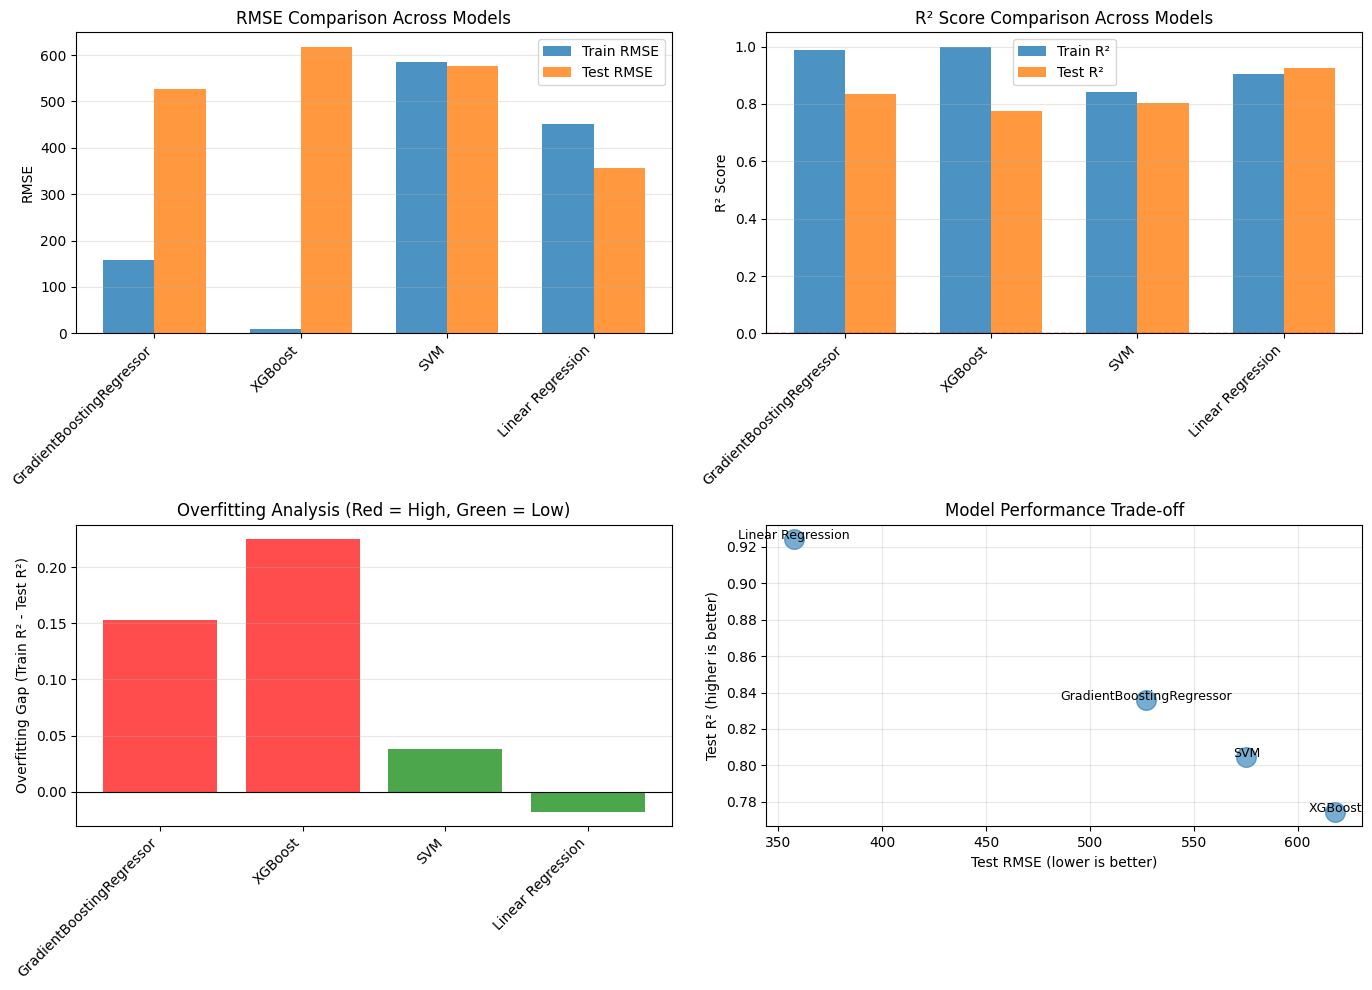


Visualization complete!


In [45]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Test RMSE Comparison
models = comparison_df['Model']
x_pos = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x_pos - width/2, comparison_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, comparison_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE Comparison Across Models')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Test R² Comparison
axes[0, 1].bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Score Comparison Across Models')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)

# Plot 3: Overfitting Analysis (Train vs Test R²)
overfitting = comparison_df['Train R²'] - comparison_df['Test R²']
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting]
axes[1, 0].bar(x_pos, overfitting, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Overfitting Gap (Train R² - Test R²)')
axes[1, 0].set_title('Overfitting Analysis (Red = High, Green = Low)')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Model Score Summary
axes[1, 1].scatter(comparison_df['Test RMSE'], comparison_df['Test R²'], s=200, alpha=0.6)
for i, model in enumerate(models):
    axes[1, 1].annotate(model, (comparison_df.iloc[i]['Test RMSE'], comparison_df.iloc[i]['Test R²']), 
                        fontsize=9, ha='center')
axes[1, 1].set_xlabel('Test RMSE (lower is better)')
axes[1, 1].set_ylabel('Test R² (higher is better)')
axes[1, 1].set_title('Model Performance Trade-off')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")
